# 비매너 댓글 식별

# 1. 라이브러리 로드 & 환경설정

In [1]:
import pandas as pd
import numpy as np 
import os
import json
import random
import shutil

from attrdict import AttrDict

from sklearn.metrics import f1_score
from datetime import datetime, timezone, timedelta
import random
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils import *
from torch.optim import Adam, AdamW

from transformers import logging, get_linear_schedule_with_warmup

from transformers import (
    BertTokenizer,  
    AutoTokenizer,
    ElectraTokenizer,
    AlbertTokenizer
)

from transformers import (
    BertModel,
    AutoModel, 
    ElectraForSequenceClassification,
    BertForSequenceClassification,
    AlbertForSequenceClassification
)

### 1-1 DEVICE 설정

In [2]:
# 사용할 GPU 지정
print("number of GPUs: ", torch.cuda.device_count())
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
use_cuda = torch.cuda.is_available()
print("Does GPU exist? : ", use_cuda)
DEVICE = torch.device("cuda" if use_cuda else "cpu")

number of GPUs:  1
Does GPU exist? :  True


### 1-2 DEBUG 설정

In [3]:
# True 일 때 코드를 실행하면 example 등을 보여줌
DEBUG = True

### Config 설정

In [4]:
config_path = os.path.join('config', 'config.json')
print(config_path)

# config 적용 
def set_config(config_path):
    if os.path.lexists(config_path):
        with open(config_path, 'r') as f:
            args = AttrDict(json.load(f))
            
            print('config file loaded')
            print(args.pretrained_model)
    else:
        assert False, 'config json file cannot be found.. please check the path again.'
        
    return args

args = set_config(config_path)

os.makedirs(args.result_dir, exist_ok=True)
os.makedirs(args.config_dir, exist_ok=True)

config/config.json
config file loaded
beomi/KcELECTRA-base


# 2. EDA

## 2-1. Train data 로드

In [5]:
train_path = os.path.join(args.data_dir, 'train.csv')

## 2-2 Train data 확인

In [6]:
train_df = pd.read_csv(train_path, encoding='UTF-8-SIG')
train_df.head()

,title,comment,bias,hate
0,"""'미스터 션샤인' 변요한, 김태리와 같은 양복 입고 학당 방문! 이유는?""",김태리 정말 연기잘해 진짜,none,none
1,"""[SC현장]""""극사실주의 현실♥""""…'가장 보통의 연애' 김래원X공효진, 16년만...",공효진 발연기나이질생각이읍던데 왜계속주연일까,none,hate
2,"""손연재, 리듬체조 학원 선생님 """"하고 싶은 일 해서 행복하다""""""",누구처럼 돈만 밝히는 저급인생은 살아가지마시길~~ 행복은 머니순이 아니니깐 작은거에...,others,hate
3,"""'섹션TV' 김해숙 """"'허스토리' 촬영 후 우울증 얻었다""""""",일본 축구 져라,none,none
4,"""[단독] 임현주 아나운서 “‘노브라 챌린지’ 방송 덕에 낸 용기, 자연스런 논의의...",난 절대로 임현주 욕하는인간이랑은 안논다 @.@,none,none


In [7]:
print("train data 개수 : ", len(train_df))

train data 개수 :  8367


## 2-3 Train 데이터 분포

title의 길이 분포

<AxesSubplot:>

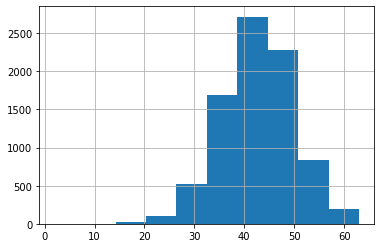

In [8]:
ax = train_df['title'].str.len().hist()
ax

In [9]:
print('title 최대 길이 : ', train_df['title'].str.len().max())
print('title 평균 길이 : ', train_df['title'].str.len().mean())

title 최대 길이 :  63
title 평균 길이 :  42.4844030118322


<AxesSubplot:>

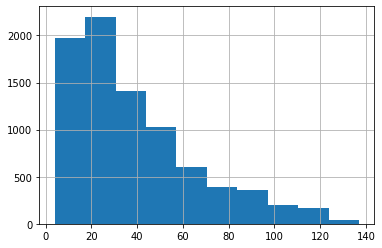

In [10]:
ax = train_df['comment'].str.len().hist()

print()

ax

In [11]:
print('comment 최대 길이 : ', train_df['comment'].str.len().max())
print('comment 평균 길이 : ', train_df['comment'].str.len().mean())

comment 최대 길이 :  137
comment 평균 길이 :  38.72439345046014


### bias와 hate 비중

In [12]:
print('bias 클래스 : ', train_df.bias.unique())
print('hate 클래스 : ', train_df.hate.unique())

bias 클래스 :  ['none' 'others' 'gender']
hate 클래스 :  ['none' 'hate']


**bias 수**

bias-none 개수 : 5490 / 비율 : 65.61%
bias-others 개수 : 1578 / 비율 : 18.86%
bias-gender 개수 : 1299 / 비율 : 15.53%


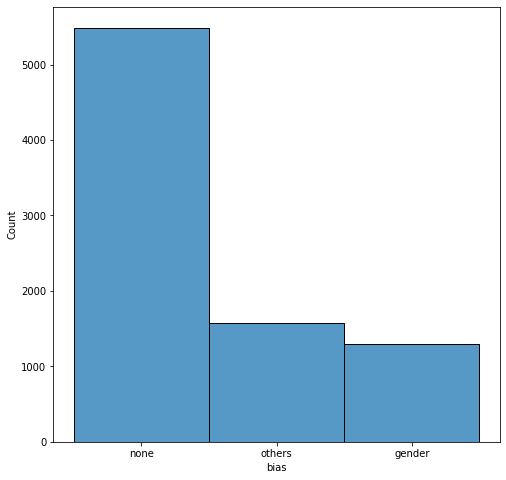

In [13]:
plt.figure(figsize=(8, 8))
sns.histplot(x=train_df['bias'])

count_none = sum(train_df.bias == 'none')
count_others = sum(train_df.bias == 'others')
count_gender = sum(train_df.bias == 'gender')

print(f'bias-none 개수 : {count_none} / 비율 : {round(count_none/len(train_df)*100, 2)}%')
print(f'bias-others 개수 : {count_others} / 비율 : {round(count_others/len(train_df)*100, 2)}%')
print(f'bias-gender 개수 : {count_gender} / 비율 : {round(count_gender/len(train_df)*100, 2)}%')
plt.show()

**hate 수**

hate-none 개수 : 3646 / 비율 : 43.58%
hate-hate 개수 : 4721 / 비율 : 56.42%


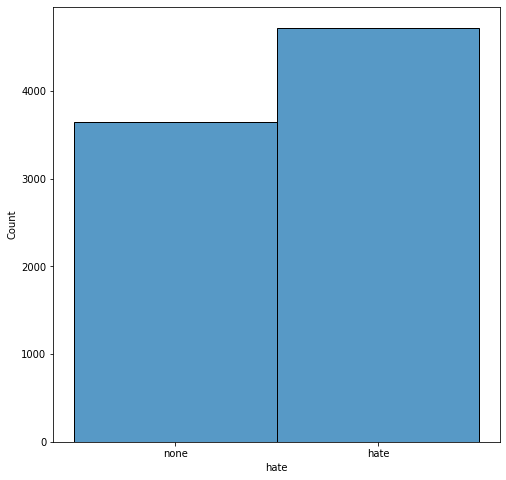

In [14]:
plt.figure(figsize=(8, 8))
sns.histplot(x=train_df['hate'])

count_hate_none = sum(train_df.hate == 'none')
count_hate_hate = sum(train_df.hate == 'hate')

print(f'hate-none 개수 : {count_hate_none} / 비율 : {round(count_hate_none/len(train_df)*100, 2)}%')
print(f'hate-hate 개수 : {count_hate_hate} / 비율 : {round(count_hate_hate/len(train_df)*100, 2)}%')

plt.show()

**bias, hate 비율**

In [15]:
len(train_df['title'])

8367

In [16]:
bias_hate = train_df.iloc[:, 1:].pivot_table(index='bias', columns='hate', aggfunc='count')
bias_hate

comment      
hate      hate  none
bias                
gender    1216    83
none      2068  3422
others    1437   141

Text(0.5, 1.0, 'bias-hate heat map')

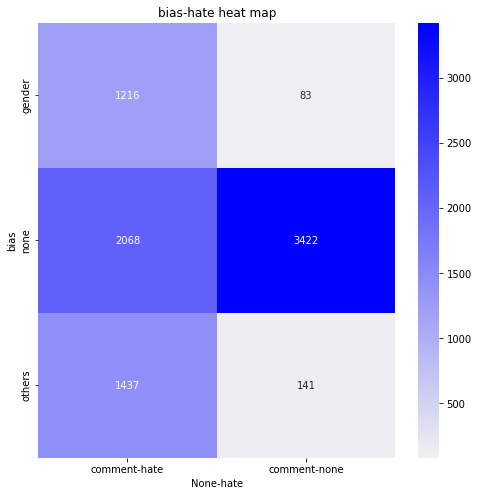

In [17]:
plt.figure(figsize=(8, 8))

sns.heatmap(bias_hate, cmap=sns.light_palette('blue', as_cmap=True), annot=True, fmt='g')
plt.title("bias-hate heat map")

bias와 hate의 관계성? 연관성이 존재하는가?? 

## 2-5. Test 데이터 로드

In [18]:
test_path = os.path.join(args.data_dir,'test.csv')
print("test 데이터 경로가 올바른가요? : ", os.path.lexists(test_path))

test 데이터 경로가 올바른가요? :  True


In [19]:
test_df = pd.read_csv(test_path)
test_df.head()

,ID,title,comment
0,0,"류현경♥︎박성훈, 공개연애 4년차 애정전선 이상無..""의지 많이 된다""[종합]",둘다 넘 좋다~행복하세요
1,1,"""현금 유도+1인 1라면?""…'골목식당' 백종원, 초심 잃은 도시락집에 '경악' [종합]",근데 만원이하는 현금결제만 하라고 써놓은집 우리나라에 엄청 많은데
2,2,"입대 D-11' 서은광의 슬픈 멜로디..비투비, 눈물의 첫 체조경기장[콘서트 종합]",누군데 얘네?
3,3,"아이콘택트' 리쌍 길, 3년 전 결혼설 부인한 이유 공개…""결혼,출산 숨겼다""","쑈 하지마라 짜식아!음주 1번은 실수, 2번은 고의, 3번은 인간쓰레기다.슬금슬금 ..."
4,4,"구하라, 안검하수 반박 해프닝...""당당하다""vs""그렇게까지"" 설전 [종합]",안검하수 가지고 있는 분께 희망을 주고 싶은건가요? 수술하면 이렇게 자연스러워진다고...


<AxesSubplot:>

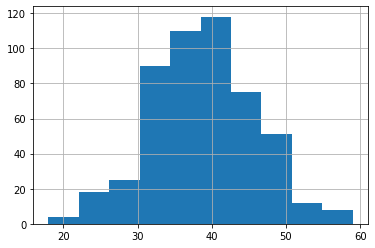

In [20]:
ax = test_df['title'].str.len().hist()
ax

In [21]:
print('title 최대 길이 : ', test_df['title'].str.len().max())
print('title 평균 길이 : ', test_df['title'].str.len().mean())

title 최대 길이 :  59
title 평균 길이 :  38.86888454011741


<AxesSubplot:>

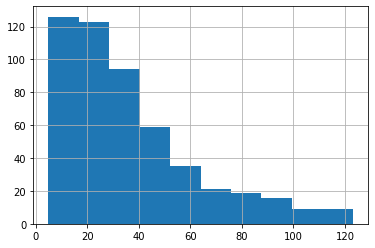

In [22]:
ax = test_df['comment'].str.len().hist()

print()

ax

In [23]:
print('comment 최대 길이 : ', test_df['comment'].str.len().max())
print('comment 평균 길이 : ', test_df['comment'].str.len().mean())

comment 최대 길이 :  123
comment 평균 길이 :  36.31311154598826


# 3. 데이터 전처리

## 3-1. 라벨값 추가

In [24]:
# 두 라벨의 가능한 모든 조합 만들기
combinations = np.array(np.meshgrid(train_df.bias.unique(), train_df.hate.unique())).T.reshape(-1,2)

if DEBUG==True:
    print(combinations)

[['none' 'none']
 ['none' 'hate']
 ['others' 'none']
 ['others' 'hate']
 ['gender' 'none']
 ['gender' 'hate']]


In [25]:
# bias, hate 컬럼을 합친 것
bias_hate = list(np.array([train_df['bias'].values, train_df['hate'].values]).T.reshape(-1,2))

if DEBUG==True:
    print(bias_hate[:5])


[array(['none', 'none'], dtype=object), array(['none', 'hate'], dtype=object), array(['others', 'hate'], dtype=object), array(['none', 'none'], dtype=object), array(['none', 'none'], dtype=object)]


In [26]:
labels = []
for i, arr in enumerate(bias_hate):
    for idx, elem in enumerate(combinations):
        if np.array_equal(elem, arr):
            labels.append(idx)

train_df['label'] = labels
train_df.head()

,title,comment,bias,hate,label
0,"""'미스터 션샤인' 변요한, 김태리와 같은 양복 입고 학당 방문! 이유는?""",김태리 정말 연기잘해 진짜,none,none,0
1,"""[SC현장]""""극사실주의 현실♥""""…'가장 보통의 연애' 김래원X공효진, 16년만...",공효진 발연기나이질생각이읍던데 왜계속주연일까,none,hate,1
2,"""손연재, 리듬체조 학원 선생님 """"하고 싶은 일 해서 행복하다""""""",누구처럼 돈만 밝히는 저급인생은 살아가지마시길~~ 행복은 머니순이 아니니깐 작은거에...,others,hate,3
3,"""'섹션TV' 김해숙 """"'허스토리' 촬영 후 우울증 얻었다""""""",일본 축구 져라,none,none,0
4,"""[단독] 임현주 아나운서 “‘노브라 챌린지’ 방송 덕에 낸 용기, 자연스런 논의의...",난 절대로 임현주 욕하는인간이랑은 안논다 @.@,none,none,0


# 4. Dataset 로드 

In [27]:
# config.json 에서 지정 이름별로 가져올 라이브러리 지정

from transformers import AutoTokenizer, AutoModel

TOKENIZER_CLASSES = {
    "BertTokenizer": BertTokenizer,
    "AutoTokenizer": AutoTokenizer,
    "ElectraTokenizer": ElectraTokenizer,
    "AlbertTokenizer": AlbertTokenizer,
    "AutoTokenizer": AutoTokenizer
}

In [28]:
TOKENIZER = TOKENIZER_CLASSES[args.tokenizer_class].from_pretrained(args.pretrained_model)
if DEBUG==True:
    print(TOKENIZER)

PreTrainedTokenizerFast(name_or_path='beomi/KcELECTRA-base', vocab_size=50135, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


In [29]:
if DEBUG == True:
    example = train_df['title'][0]
    print('example : ', example)
    
    comment_ex = train_df['comment'][0]
    print('comment_ex : ', comment_ex)
    
    print(TOKENIZER(example, comment_ex))

example :  "'미스터 션샤인' 변요한, 김태리와 같은 양복 입고 학당 방문! 이유는?"
comment_ex :  김태리 정말 연기잘해 진짜
{'input_ids': [2, 6, 11, 24787, 2089, 5146, 4028, 11, 1709, 4071, 4069, 16, 20778, 4177, 4331, 8069, 35054, 12634, 47185, 13182, 5, 10491, 33, 6, 3, 20778, 4177, 8057, 11061, 4479, 4025, 7997, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [30]:
if DEBUG == True:
    print('encode : ', TOKENIZER.encode(example), "\n")
    
    print('tokenize : ', TOKENIZER.tokenize(example), "\n")
    
    print('convert tokens to ids : ', TOKENIZER.tokenize(example))

encode :  [2, 6, 11, 24787, 2089, 5146, 4028, 11, 1709, 4071, 4069, 16, 20778, 4177, 4331, 8069, 35054, 12634, 47185, 13182, 5, 10491, 33, 6, 3] 

tokenize :  ['"', "'", '미스터', '션', '##샤', '##인', "'", '변', '##요', '##한', ',', '김태', '##리', '##와', '같은', '양복', '입고', '학당', '방문', '!', '이유는', '?', '"'] 

convert tokens to ids :  ['"', "'", '미스터', '션', '##샤', '##인', "'", '변', '##요', '##한', ',', '김태', '##리', '##와', '같은', '양복', '입고', '학당', '방문', '!', '이유는', '?', '"']


## 4-1. 데이터 정제 함수 정의

In [31]:
import re
import emoji
from soynlp.normalizer import repeat_normalize

emojis = ''.join(emoji.UNICODE_EMOJI.keys())
pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣{emojis}]+')
url_pattern = re.compile(
    r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

def clean_text(x):
    x = pattern.sub(' ', x)
    x = url_pattern.sub('', x)
    x = x.strip()
    x = repeat_normalize(x, num_repeats=2)
    return x

In [32]:
x = clean_text("'미스터 션샤인' 변요한, ㅋㅋㅋㅋㅋ     김태리와 같은 양복 입고 학당 방문! 이유는?????")
print(x)

'미스터 션샤인' 변요한, ㅋㅋ 김태리와 같은 양복 입고 학당 방문! 이유는?????


## 4-1. Dataset 함수 정의

In [33]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, mode='train', clean=None):
        self.data = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.mode = mode
        self.clean = clean
        
        if self.mode != 'test':
            try:
                self.labels = df['label'].tolist()
            except:
                assert False, "CustomDataset Error! : \'label\' columns does not exist in the dataframe. check mode is not train"
    
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, idx):
        title = self.data.title.iloc[idx]
        comment = self.data.comment.iloc[idx]
        
        if self.clean is not None:
            title = self.clean(title)
            comment = self.clean(comment)
        
        
        tokenized_text = self.tokenizer(title,
                                       comment,
                                       padding='max_length',
                                       max_length=self.max_len,
                                       truncation=True,
                                       return_token_type_ids=True,
                                       return_attention_mask=True,
                                       return_tensors='pt')
        data = {
            'input_ids': tokenized_text['input_ids'].clone().detach().long(),
            'attention_mask': tokenized_text['attention_mask'].clone().detach().long(),
            'token_type_ids': tokenized_text['token_type_ids'].clone().detach().long()
        }
        
        if self.mode != 'test':
            label = self.data.label.iloc[idx]
            return data, label
        else:
            return data

In [34]:
train_dataset = CustomDataset(df=train_df, tokenizer=TOKENIZER, max_len=args.max_seq_len, mode='train', clean=clean_text)
print("train dataset loaded.")

train dataset loaded.


In [35]:
if DEBUG == True:
    print('dataset sample : ')
    print(train_dataset[0])

dataset sample : 
({'input_ids': tensor([[    2,     6,    11, 24787,  2089,  5146,  4028,    11,  1709,  4071,
          4069,    16, 20778,  4177,  4331,  8069, 35054, 12634, 47185, 13182,
             5, 10491,    33,     6,     3, 20778,  4177,  8057, 11061,  4479,
          4025,  7997,     3,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,    

## 4-3. Train/Validation set 나누기

In [36]:
from sklearn.model_selection import train_test_split
                                                         
train_data, val_data = train_test_split(train_df, test_size=0.1, random_state=args.seed)

train_dataset = CustomDataset(train_data, TOKENIZER, args.max_seq_len, 'train', clean_text)
val_dataset = CustomDataset(val_data, TOKENIZER, args.max_seq_len, 'validation', clean_text)

print("Train dataset: ", len(train_dataset))
print("Validation dataset: ", len(val_dataset))

Train dataset:  7530
Validation dataset:  837


# 5. 분류 모델 세팅

In [37]:
from transformers import logging
logging.set_verbosity_error()

BASE_MODEL = {
    "BertForSequenceClassification": BertForSequenceClassification,
    "AutoModel": AutoModel,
    "ElectraForSequenceClassification": ElectraForSequenceClassification,
    "AlbertForSequenceClassification": AlbertForSequenceClassification,
}

In [38]:
myModel = BASE_MODEL[args.architecture].from_pretrained(args.pretrained_model,
                                                       num_labels = args.num_classes,
                                                       output_attentions=False, 
                                                       output_hidden_states=True)

In [39]:
if DEBUG == True:
    print(myModel)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(50135, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [40]:
### v2 에서 일부 수정됨
class myClassifier(nn.Module):
    def __init__(self, model, hidden_size = 768, num_classes=args.num_classes, selected_layers=False, params=None):
        super(myClassifier, self).__init__()
        self.model = model
        self.softmax = nn.Softmax(dim=1) 
        self.selected_layers = selected_layers
        
        # 사실 dr rate은 model config 에서 hidden_dropout_prob로 가져와야 하는데 bert에선 0.1이 쓰였음
        self.dropout = nn.Dropout(0.1)


    def forward(self, token_ids, attention_mask, segment_ids):      
        outputs = self.model(input_ids = token_ids, 
                             token_type_ids = segment_ids.long(), 
                             attention_mask = attention_mask.float().to(token_ids.device))
        
        # hidden state에서 마지막 4개 레이어를 뽑아 합쳐 새로운 pooled output 을 만드는 시도
        if self.selected_layers == True:
            hidden_states = outputs.hidden_states
            pooled_output = torch.cat(tuple([hidden_states[i] for i in [-4, -3, -2, -1]]), dim=-1)
            # print("concatenated output shape: ", pooled_output.shape)
            ## dim(batch_size, max_seq_len, hidden_dim) 에서 가운데를 0이라 지정함으로, [cls] 토큰의 임베딩을 가져온다. 
            ## (text classification 구조 참고)
            pooled_output = pooled_output[:, 0, :]
            # print(pooled_output)

            pooled_output = self.dropout(pooled_output)

            ## 3개의 레이어를 합치므로 classifier의 차원은 (hidden_dim, 6)이다
            classifier = nn.Linear(pooled_output.shape[1], args.num_classes).to(token_ids.device)
            logits = classifier(pooled_output)
        
        else:
            logits=outputs.logits
        
    
        # 각 클래스별 확률
        prob= self.softmax(logits)
        # print(prob)
        # logits2 = outputs.logits
        # print(self.softmax(logits2))


        return logits, prob
        
# 마지막 4 hidden layers concat 하는 방법을 쓰신다면 True로 변경        
model = myClassifier(myModel, selected_layers=False)

# if DEBUG ==True :
#     print(model)

In [41]:
if DEBUG==True:
    params = list(model.named_parameters())

    print('The BERT model has {:} different named parameters.\n'.format(len(params)))

    print('==== Embedding Layer ====\n')

    for p in params[0:5]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

    print('\n==== First Transformer ====\n')

    for p in params[5:21]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

    print('\n==== Output Layer ====\n')

    for p in params[-4:]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

model.electra.embeddings.word_embeddings.weight         (50135, 768)
model.electra.embeddings.position_embeddings.weight       (512, 768)
model.electra.embeddings.token_type_embeddings.weight       (2, 768)
model.electra.embeddings.LayerNorm.weight                     (768,)
model.electra.embeddings.LayerNorm.bias                       (768,)

==== First Transformer ====

model.electra.encoder.layer.0.attention.self.query.weight   (768, 768)
model.electra.encoder.layer.0.attention.self.query.bias       (768,)
model.electra.encoder.layer.0.attention.self.key.weight   (768, 768)
model.electra.encoder.layer.0.attention.self.key.bias         (768,)
model.electra.encoder.layer.0.attention.self.value.weight   (768, 768)
model.electra.encoder.layer.0.attention.self.value.bias       (768,)
model.electra.encoder.layer.0.attention.output.dense.weight   (768, 768)
model.electra.encoder.layer.0.attention.output.dense.bi

# 6. 학습

## 6-1. Early Stopper 함수 정의

In [42]:
class LossEarlyStopper():
    """Early stopper

        patience (int): loss가 줄어들지 않아도 학습할 epoch 수
        patience_counter (int): loss 가 줄어들지 않을 때 마다 1씩 증가
        min_loss (float): 최소 loss
        stop (bool): True 일 때 학습 중단

    """

    def __init__(self, patience: int)-> None:
        """ 초기화

        Args:
            patience (int): loss가 줄어들지 않아도 학습할 epoch 수
            weight_path (str): weight 저장경로
            verbose (bool): 로그 출력 여부, True 일 때 로그 출력
        """
        self.patience = patience
        self.patience_counter = 0
        self.min_loss = np.Inf
        self.stop = False

    def check_early_stopping(self, loss: float)-> None:
        # 첫 에폭
        if self.min_loss == np.Inf:
            self.min_loss = loss
           
        # loss가 줄지 않는다면 -> patience_counter 1 증가
        elif loss > self.min_loss:
            self.patience_counter += 1
            msg = f"Early stopping counter {self.patience_counter}/{self.patience}"

            # patience 만큼 loss가 줄지 않았다면 학습을 중단합니다.
            if self.patience_counter == self.patience:
                self.stop = True
            print(msg)
        # loss가 줄어듬 -> min_loss 갱신, patience_counter 초기화
        elif loss <= self.min_loss:
            self.patience_counter = 0
            ### v2 에서 수정됨
            ### self.save_model = True -> 삭제 (사용하지 않음)
            msg = f"Validation loss decreased {self.min_loss} -> {loss}"
            self.min_loss = loss

            print(msg)

## 6-2. Epoch 별 학습 및 검증

- [Transformers optimization documentation](https://huggingface.co/docs/transformers/main_classes/optimizer_schedules)
- [스케줄러 documentation](https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#schedules)
- Adam optimizer의 epsilon 파라미터 eps = 1e-8 는 "계산 중 0으로 나눔을 방지 하기 위한 아주 작은 숫자 " 입니다. ([출처](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/))
- 스케줄러 파라미터
    - `warmup_ratio` : 
      - 학습이 진행되면서 학습률을 그 상황에 맞게 가변적으로 적당하게 변경되게 하기 위해 Scheduler를 사용합니다.
      - 처음 학습률(Learning rate)를 warm up하기 위한 비율을 설정하는 warmup_ratio을 설정합니다.
  

In [43]:
args = set_config(config_path)

logging.set_verbosity_warning()

# 재현을 위해 모든 곳의 시드 고정
seed_val = args.seed
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def train(model, train_data, val_data, args, mode = 'train'):
    
    # args.run은 실험 이름 (어디까지나 팀원들간의 버전 관리 및 공유 편의를 위한 것으로, 자유롭게 수정 가능합니다.)
    print("RUN : ", args.run)
    shutil.copyfile("config/config.json", os.path.join(args.config_dir, f"config_{args.run}.json"))

    early_stopper = LossEarlyStopper(patience=args.patience)
    
    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=args.train_batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=args.train_batch_size)

    
    if DEBUG == True:
        # 데이터로더가 성공적으로 로드 되었는지 확인
        for idx, data in enumerate(train_dataloader):
            if idx==0:
                print("batch size : ", len(data[0]['input_ids']))
                print("The first batch looks like ..\n", data[0])
    
    
    criterion = nn.CrossEntropyLoss()
    
    total_steps = len(train_dataloader) * args.train_epochs

    ### v2에서 수정됨 (Adam -> AdamW)
    optimizer = AdamW(model.parameters(), lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(total_steps * args.warmup_proportion), 
                                                num_training_steps=total_steps)

    
    if use_cuda:
        model = model.to(DEVICE)
        criterion = criterion.to(DEVICE)
        

    tr_loss = 0.0
    val_loss = 0.0
    best_score = 0.0
    best_loss = np.inf
      

    for epoch_num in range(args.train_epochs):

            total_acc_train = 0
            total_loss_train = 0
            
            assert mode in ['train', 'val'], 'your mode should be either \'train\' or \'val\''
            
            if mode =='train':
                for train_input, train_label in tqdm(train_dataloader):
                    print(train_input, train_label)
                    print(type(train_label))
                    
                    mask = train_input['attention_mask'].to(DEVICE)
                    input_id = train_input['input_ids'].squeeze(1).to(DEVICE)
                    segment_ids = train_input['token_type_ids'].squeeze(1).to(DEVICE)
                    train_label = train_label.long().to(DEVICE)  
                    
                    ### v2에 수정됨
                    optimizer.zero_grad()
 
                    output = model(input_id, mask, segment_ids)
                    batch_loss = criterion(output[0].view(-1,6), train_label.view(-1))
                    total_loss_train += batch_loss.item()

                    acc = (output[0].argmax(dim=1) == train_label).sum().item()
                    total_acc_train += acc
                    
                    ### v2에 수정됨
                    optimizer.zero_grad()
                    
                    batch_loss.backward()
                    optimizer.step()
                    
                    ### v2 에 수정됨
                    scheduler.step()
                    

            total_acc_val = 0
            total_loss_val = 0
            
            # validation을 위해 이걸 넣으면 이 evaluation 프로세스 중엔 dropout 레이어가 다르가 동작한다.
            model.eval()
            
            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    mask = val_input['attention_mask'].to(DEVICE)
                    input_id = val_input['input_ids'].squeeze(1).to(DEVICE)
                    segment_ids = val_input['token_type_ids'].squeeze(1).to(DEVICE)
                    val_label = val_label.long().to(DEVICE)

                    output = model(input_id, mask, segment_ids)
                    ### v2 에서 일부 수정 (output -> output[0]로 myClassifier 모델에 정의된대로 logits 가져옴)
                    batch_loss = criterion(output[0].view(-1,6), val_label.view(-1))
                    total_loss_val += batch_loss.item()
                    
                    ### v2 에서 일부 수정 (output -> output[0]로 myClassifier 모델에 정의된대로 logits 가져옴)
                    acc = (output[0].argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            
            train_loss = total_loss_train / len(train_data)
            train_accuracy = total_acc_train / len(train_data)
            val_loss = total_loss_val / len(val_data)
            val_accuracy = total_acc_val / len(val_data)
            
            # 한 Epoch 학습 후 학습/검증에 대해 loss와 평가지표 (여기서는 accuracy로 임의로 설정) 출력
            print(
                f'Epoch: {epoch_num + 1} \
                | Train Loss: {train_loss: .3f} \
                | Train Accuracy: {train_accuracy: .3f} \
                | Val Loss: {val_loss: .3f} \
                | Val Accuracy: {val_accuracy: .3f}')
          
            # early_stopping check
            early_stopper.check_early_stopping(loss=val_loss)

            if early_stopper.stop:
                print('Early stopped, Best score : ', best_score)
                break

            ### v2 에 수정됨
            ### loss와 accuracy가 꼭 correlate하진 않습니다.
            ### 
            ### 원본 (필요하다면 다시 해제 후 사용)
            # if val_accuracy > best_score : 
            if val_loss < best_loss :
            # 모델이 개선됨 -> 검증 점수와 베스트 loss, weight 갱신
                best_score = val_accuracy 
                
                ### v2에서 추가
                best_loss =val_loss
                # 학습된 모델을 저장할 디렉토리 및 모델 이름 지정
                SAVED_MODEL =  os.path.join(args.result_dir, f'best_{args.run}.pt')
            
                check_point = {
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'scheduler': scheduler.state_dict()
                }
                torch.save(check_point, SAVED_MODEL)  
              
            # print("scheduler : ", scheduler.state_dict())


    print("train finished")


train(model, train_dataset, val_dataset, args, mode = 'train')

config file loaded
beomi/KcELECTRA-base
RUN :  demo3
batch size :  20
The first batch looks like ..
 {'input_ids': tensor([[[    2,     6,    11,  ...,     0,     0,     0]],

        [[    2,     6,    61,  ...,     0,     0,     0]],

        [[    2,     6,    61,  ...,     0,     0,     0]],

        ...,

        [[    2,     6, 29663,  ...,     0,     0,     0]],

        [[    2,     6,    11,  ...,     0,     0,     0]],

        [[    2,    11,   163,  ...,     0,     0,     0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        ...,

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0

  0% 0/377 [00:00<?, ?it/s]

{'input_ids': tensor([[[    2,     6,  2484,  ...,     0,     0,     0]],

        [[    2,     6,    61,  ...,     0,     0,     0]],

        [[    2,     6,    11,  ...,     0,     0,     0]],

        ...,

        [[    2,     6, 27805,  ...,     0,     0,     0]],

        [[    2,   591,  8895,  ...,     0,     0,     0]],

        [[    2,     6,    61,  ...,     0,     0,     0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        ...,

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]])} tensor([5, 3, 3, 0, 5, 1, 0, 5, 0, 0, 0, 0, 0, 5, 0, 0, 5, 3, 3, 0])
<class 'torch.Tensor'>


  0% 1/377 [00:00<05:48,  1.08it/s]

{'input_ids': tensor([[[    2,     6, 32314,  ...,     0,     0,     0]],

        [[    2,     6,     6,  ...,     0,     0,     0]],

        [[    2,     6, 30483,  ...,     0,     0,     0]],

        ...,

        [[    2,     6,    11,  ...,     0,     0,     0]],

        [[    2,     6,    11,  ...,     0,     0,     0]],

        [[    2,     6,     6,  ...,     0,     0,     0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        ...,

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]])} tensor([5, 1, 0, 0, 5, 0, 2, 0, 2, 3, 3, 5, 1, 1, 0, 0, 3, 3, 0, 0])
<class 'torch.Tensor'>


  1% 2/377 [00:01<04:51,  1.29it/s]

{'input_ids': tensor([[[    2,     6,     6,  ...,     0,     0,     0]],

        [[    2,     6,    11,  ...,     0,     0,     0]],

        [[    2,     6,     6,  ...,     0,     0,     0]],

        ...,

        [[    2,     6, 36275,  ...,     0,     0,     0]],

        [[    2,     6,     6,  ...,     0,     0,     0]],

        [[    2,     6, 19000,  ...,     0,     0,     0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        ...,

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]])} tensor([5, 0, 3, 0, 5, 0, 1, 1, 0, 0, 1, 0, 0, 3, 3, 5, 1, 1, 0, 1])
<class 'torch.Tensor'>


  1% 3/377 [00:01<04:12,  1.48it/s]

{'input_ids': tensor([[[    2,     6, 10657,  ...,     0,     0,     0]],

        [[    2,     6,    11,  ...,     0,     0,     0]],

        [[    2,     6, 31241,  ...,     0,     0,     0]],

        ...,

        [[    2,     6,  9319,  ...,     0,     0,     0]],

        [[    2,    61, 18398,  ...,     0,     0,     0]],

        [[    2,     6,    61,  ...,     0,     0,     0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        ...,

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]])} tensor([0, 0, 1, 2, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 3, 3, 1, 5, 5, 0])
<class 'torch.Tensor'>


  1% 4/377 [00:02<03:43,  1.67it/s]

{'input_ids': tensor([[[    2,     6,    61,  ...,     0,     0,     0]],

        [[    2,     6,   264,  ...,     0,     0,     0]],

        [[    2,     6,    11,  ...,     0,     0,     0]],

        ...,

        [[    2,     6,    61,  ...,     0,     0,     0]],

        [[    2, 31610,    97,  ...,     0,     0,     0]],

        [[    2, 37338,  4486,  ...,     0,     0,     0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        ...,

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]])} tensor([1, 4, 0, 0, 3, 0, 5, 5, 1, 1, 0, 3, 1, 5, 0, 0, 0, 3, 5, 5])
<class 'torch.Tensor'>


  1% 5/377 [00:02<03:23,  1.83it/s]

{'input_ids': tensor([[[    2,     6, 29573,  ...,     0,     0,     0]],

        [[    2,     6, 15877,  ...,     0,     0,     0]],

        [[    2,     6,    61,  ...,     0,     0,     0]],

        ...,

        [[    2,     6,    61,  ...,     0,     0,     0]],

        [[    2,     6,    61,  ...,     0,     0,     0]],

        [[    2,     6,    61,  ...,     0,     0,     0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        ...,

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]])} tensor([1, 3, 0, 1, 0, 3, 1, 1, 5, 5, 3, 0, 5, 0, 5, 0, 0, 1, 3, 1])
<class 'torch.Tensor'>


  2% 6/377 [00:03<03:10,  1.95it/s]

{'input_ids': tensor([[[    2,     6, 37150,  ...,     0,     0,     0]],

        [[    2, 34525,  4608,  ...,     0,     0,     0]],

        [[    2,     6,    61,  ...,     0,     0,     0]],

        ...,

        [[    2,     6,  3222,  ...,     0,     0,     0]],

        [[    2,     6,    61,  ...,     0,     0,     0]],

        [[    2,     6,    11,  ...,     0,     0,     0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        ...,

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]])} tensor([1, 5, 5, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0, 3, 1, 5, 0, 0, 0, 0])
<class 'torch.Tensor'>


  2% 7/377 [00:03<03:00,  2.05it/s]

{'input_ids': tensor([[[    2,     6, 17010,  ...,     0,     0,     0]],

        [[    2,     6, 31760,  ...,     0,     0,     0]],

        [[    2,     6,  3777,  ...,     0,     0,     0]],

        ...,

        [[    2,     6, 19445,  ...,     0,     0,     0]],

        [[    2,     6,   602,  ...,     0,     0,     0]],

        [[    2,     6,    61,  ...,     0,     0,     0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        ...,

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]])} tensor([0, 1, 2, 1, 0, 0, 0, 3, 1, 0, 0, 1, 3, 0, 1, 1, 0, 5, 1, 1])
<class 'torch.Tensor'>


  2% 8/377 [00:03<02:54,  2.12it/s]

{'input_ids': tensor([[[    2,     6, 48875,  ...,     0,     0,     0]],

        [[    2,     6, 27899,  ...,     0,     0,     0]],

        [[    2,     6, 44032,  ...,     0,     0,     0]],

        ...,

        [[    2,     6,     6,  ...,     0,     0,     0]],

        [[    2,     6, 30043,  ...,     0,     0,     0]],

        [[    2,     6,    11,  ...,     0,     0,     0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        ...,

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]])} tensor([0, 5, 3, 0, 5, 0, 0, 1, 1, 1, 0, 1, 3, 5, 5, 5, 0, 3, 1, 3])
<class 'torch.Tensor'>


  2% 9/377 [00:04<02:48,  2.18it/s]

{'input_ids': tensor([[[    2,     6,    61,  ...,     0,     0,     0]],

        [[    2, 33078,    97,  ...,     0,     0,     0]],

        [[    2,     6,  8899,  ...,     0,     0,     0]],

        ...,

        [[    2,     6, 40010,  ...,     0,     0,     0]],

        [[    2,     6,    11,  ...,     0,     0,     0]],

        [[    2,     6,    61,  ...,     0,     0,     0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        ...,

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]])} tensor([3, 3, 0, 0, 0, 0, 0, 1, 1, 3, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0])
<class 'torch.Tensor'>


  3% 10/377 [00:04<02:45,  2.22it/s]

{'input_ids': tensor([[[    2,     6,    61,  ...,     0,     0,     0]],

        [[    2,     6,    11,  ...,     0,     0,     0]],

        [[    2,     6,    11,  ...,     0,     0,     0]],

        ...,

        [[    2,     6,  2693,  ...,     0,     0,     0]],

        [[    2,     6, 13857,  ...,     0,     0,     0]],

        [[    2,     6,    61,  ...,     0,     0,     0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        ...,

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]])} tensor([3, 0, 0, 3, 1, 5, 0, 3, 5, 0, 3, 0, 1, 0, 1, 0, 5, 3, 0, 3])
<class 'torch.Tensor'>


  3% 11/377 [00:05<02:43,  2.24it/s]

{'input_ids': tensor([[[    2,     6,  2484,  ...,     0,     0,     0]],

        [[    2,     6, 35348,  ...,     0,     0,     0]],

        [[    2,     6, 38845,  ...,     0,     0,     0]],

        ...,

        [[    2,     6,     6,  ...,     0,     0,     0]],

        [[    2,     6,    61,  ...,     0,     0,     0]],

        [[    2,    61,   149,  ...,     0,     0,     0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        ...,

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]])} tensor([3, 1, 3, 0, 3, 1, 0, 0, 0, 1, 3, 5, 5, 1, 3, 5, 0, 0, 1, 0])
<class 'torch.Tensor'>


  3% 12/377 [00:05<02:40,  2.27it/s]

{'input_ids': tensor([[[   2,    6,   61,  ...,    0,    0,    0]],

        [[   2,    6,    6,  ...,    0,    0,    0]],

        [[   2,    6,   61,  ...,    0,    0,    0]],

        ...,

        [[   2,    6,   61,  ...,    0,    0,    0]],

        [[   2, 9223, 8173,  ...,    0,    0,    0]],

        [[   2,    6,   11,  ...,    0,    0,    0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        ...,

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]])} tensor([1, 0, 0, 0, 0, 3, 1, 1, 0, 3, 3, 1, 0, 1, 0, 3, 3, 3, 4, 0])
<class 'torch.Tensor'>


  3% 13/377 [00:06<02:40,  2.27it/s]

{'input_ids': tensor([[[    2,     6,    11,  ...,     0,     0,     0]],

        [[    2,     6,    61,  ...,     0,     0,     0]],

        [[    2,     6,    11,  ...,     0,     0,     0]],

        ...,

        [[    2,     6,    11,  ...,     0,     0,     0]],

        [[    2,     6, 43321,  ...,     0,     0,     0]],

        [[    2,     6,    61,  ...,     0,     0,     0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        ...,

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]])} tensor([1, 5, 0, 1, 5, 0, 5, 1, 0, 3, 0, 3, 0, 1, 0, 0, 0, 0, 1, 5])
<class 'torch.Tensor'>


  4% 14/377 [00:06<02:39,  2.27it/s]

{'input_ids': tensor([[[    2,     6,     6,  ...,     0,     0,     0]],

        [[    2,     6,  2571,  ...,     0,     0,     0]],

        [[    2,     6,    61,  ...,     0,     0,     0]],

        ...,

        [[    2,     6,    11,  ...,     0,     0,     0]],

        [[    2,     6,    61,  ...,     0,     0,     0]],

        [[    2, 47354,    97,  ...,     0,     0,     0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        ...,

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]])} tensor([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 5, 3, 0, 4, 1, 1, 1])
<class 'torch.Tensor'>


  4% 15/377 [00:06<02:37,  2.29it/s]

{'input_ids': tensor([[[    2,     6, 45423,  ...,     0,     0,     0]],

        [[    2,     6,    61,  ...,     0,     0,     0]],

        [[    2,     6,    61,  ...,     0,     0,     0]],

        ...,

        [[    2,    61, 18398,  ...,     0,     0,     0]],

        [[    2,     6,  2438,  ...,     0,     0,     0]],

        [[    2, 29734,  4138,  ...,     0,     0,     0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        ...,

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]])} tensor([0, 0, 1, 5, 3, 0, 1, 0, 0, 1, 1, 3, 0, 5, 1, 1, 0, 3, 0, 0])
<class 'torch.Tensor'>


  4% 16/377 [00:07<02:47,  2.16it/s]

{'input_ids': tensor([[[    2,    11,  8320,  ...,     0,     0,     0]],

        [[    2,     6,    61,  ...,     0,     0,     0]],

        [[    2,     6,  2111,  ...,     0,     0,     0]],

        ...,

        [[    2,     6,     6,  ...,     0,     0,     0]],

        [[    2,    61, 15085,  ...,     0,     0,     0]],

        [[    2,     6,    11,  ...,     0,     0,     0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        ...,

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]])} tensor([1, 1, 3, 3, 1, 3, 0, 4, 3, 5, 0, 1, 3, 1, 5, 0, 3, 5, 5, 3])
<class 'torch.Tensor'>


KeyboardInterrupt: 

# 7. Test dataset으로 추론 (Prediction)


- v2 에서 수정된 부분
    - output -> output[0]

In [ ]:
from torch.utils.data import DataLoader

# 테스트 데이터셋 불러오기
test_data = CustomDataset(test_df, tokenizer = TOKENIZER, max_len= args.max_seq_len, mode='test')

def test(model, SAVED_MODEL, test_data, args, mode = 'test'):


    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=args.eval_batch_size)


    if use_cuda:

        model = model.to(DEVICE)
        model.load_state_dict(torch.load(SAVED_MODEL)['model'])


    model.eval()

    pred = []

    with torch.no_grad():
        for test_input in test_dataloader:

            mask = test_input['attention_mask'].to(DEVICE)
            input_id = test_input['input_ids'].squeeze(1).to(DEVICE)
            segment_ids = test_input['token_type_ids'].squeeze(1).to(DEVICE)

            output = model(input_id, mask, segment_ids)

            output = output[0].argmax(dim=1).cpu().tolist()

            for label in output:
                pred.append(label)
                
    return pred

SAVED_MODEL =  os.path.join(args.result_dir, f'best_{args.run}.pt')

pred = test(model, SAVED_MODEL, test_data, args)

In [ ]:
print("prediction completed for ", len(pred), "comments")


### 

In [ ]:
# 0-5 사이의 라벨 값 별로 bias, hate로 디코딩 하기 위한 딕셔너리
bias_dict = {0: 'none', 1: 'none', 2: 'others', 3:'others', 4:'gender', 5:'gender'}
hate_dict = {0: 'none', 1: 'hate', 2: 'none', 3:'hate', 4:'none', 5:'hate'}

# 인코딩 값으로 나온 타겟 변수를 디코딩
pred_bias = ['' for i in range(len(pred))]
pred_hate = ['' for i in range(len(pred))]

for idx, label in enumerate(pred):
    pred_bias[idx]=(str(bias_dict[label]))
    pred_hate[idx]=(str(hate_dict[label]))
print('decode Completed!')



In [ ]:
submit = pd.read_csv(os.path.join(args.data_dir,'sample_submission.csv'))
submit

In [ ]:
submit['bias'] = pred_bias
submit['hate'] = pred_hate
submit

In [ ]:
submit.to_csv(os.path.join(args.result_dir, f"submission_{args.run}.csv"), index=False)